In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip, RandomRotation
from sklearn.model_selection import train_test_split
import os
from distutils.dir_util import copy_tree, remove_tree
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [3]:
base_dir = "AlzheimerDataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
os.listdir(WORK_DIR)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.13.0


In [6]:
# Constants
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)


In [7]:
# Create the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

In [8]:
# Load images and apply data augmentation
train_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
    directory=WORK_DIR,
    image_size=DIM,
    batch_size=64,
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    labels="inferred"
)

Found 6400 files belonging to 4 classes.


In [9]:
train_data_augmented = train_data_gen.map(lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
train_data = []
train_labels = []

for data, labels in train_data_augmented:
    train_data.append(data)
    train_labels.append(labels)

train_data = tf.concat(train_data, axis=0)
train_labels = tf.concat(train_labels, axis=0)

In [12]:
# print(train_data)
print(train_labels)

tf.Tensor([0 0 0 ... 3 3 3], shape=(6400,), dtype=int32)


In [13]:
num_samples = train_data.shape[0]
train_data_2d = tf.reshape(train_data, (num_samples, -1))


In [14]:
print(train_data_2d)

tf.Tensor(
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.7898698  0.7898698  0.7898698  ... 0.59519947 0.59519947 0.59519947]
 [0.8205708  0.8205708  0.8205708  ... 0.80735004 0.80735004 0.80735004]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.87058103 0.87058103 0.87058103 ... 0.67198145 0.67198145 0.67198145]
 [0.         0.         0.         ... 0.         0.         0.        ]], shape=(6400, 92928), dtype=float32)


In [15]:
#  perform over-sampling using the Synthetic Minority Over-sampling Technique for Image Data (SMOTE-IMG)
smote_img = SMOTE(sampling_strategy='minority')

In [16]:
train_data_resampled, train_labels_resampled = smote_img.fit_resample(train_data_2d, train_labels)
# Reshape train_data_resampled back to 4D  //4D -> Batch Size , Height , Width , Color Channels
train_data_resampled = train_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [17]:
print(train_data_resampled)
train_data_resampled.shape

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

(9536, 176, 176, 3)

In [18]:
# Split the augmented data into train and test sets
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(train_data_resampled, train_labels_resampled, test_size=0.2, random_state=42,stratify=train_labels_resampled)
# Further split the train set into train and validation sets
train_data1, val_data1, train_labels1, val_labels1 = train_test_split(train_data1, train_labels1, test_size=0.2, random_state=42,stratify=train_labels1)

## --> Stratify == preserves the class distribution in the train and test split

In [19]:
from keras.utils import to_categorical

train_labels1 = to_categorical(train_labels1)
val_labels1 = to_categorical(val_labels1)

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block



In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block



In [23]:
# Define Model Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", 
                                                    save_best_only=True,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    verbose=1)

# Define Early Stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                     monitor='val_loss',
                                                     mode='min',
                                                     restore_best_weights=True,
                                                     verbose=1)

# Define Learning Rate Scheduler callback
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)



In [25]:
# Define a new model with possibly adjusted architecture
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.3),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

# Compile the new model
with strategy.scope():
    model = build_model()
    METRICS = [tf.keras.metrics.AUC(name='auc')]
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )
    model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 sequential_13 (Sequential)  (None, 44, 44, 64)        7392      
                                                                 
 sequential_14 (Sequential)  (None, 22, 22, 128)       27072     
                                                                 
 dropout_8 (Dropout)         (None, 22, 22, 128)       0         
                                                                 
 sequential_15 (Sequential)  (None, 11, 11, 256)       103296    
                                                     

In [26]:
# Train the new model with possibly adjusted parameters
history = model.fit(train_data1, train_labels1,
                    validation_data=(val_data1, val_labels1),
                    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                    epochs=20)


Epoch 1/20
191/191 [==============================] - ETA: 0s - loss: 1.2767 - auc: 0.7256
Epoch 1: val_loss improved from 30.98479 to 12.97636, saving model to best_model.h5
191/191 [==============================] - 390s 2s/step - loss: 1.2767 - auc: 0.7256 - val_loss: 12.9764 - val_auc: 0.5597 - lr: 0.0100
Epoch 2/20
191/191 [==============================] - ETA: 0s - loss: 1.1002 - auc: 0.7833
Epoch 2: val_loss improved from 12.97636 to 1.43892, saving model to best_model.h5
191/191 [==============================] - 405s 2s/step - loss: 1.1002 - auc: 0.7833 - val_loss: 1.4389 - val_auc: 0.7453 - lr: 0.0089
Epoch 3/20
191/191 [==============================] - ETA: 0s - loss: 0.8798 - auc: 0.8624
Epoch 3: val_loss did not improve from 1.43892
191/191 [==============================] - 400s 2s/step - loss: 0.8798 - auc: 0.8624 - val_loss: 15.2943 - val_auc: 0.5663 - lr: 0.0079
Epoch 4/20
191/191 [==============================] - ETA: 0s - loss: 0.8686 - auc: 0.8635
Epoch 4: val_lo

In [27]:

# Evaluate the new model
val_loss, val_auc = model.evaluate(val_data1, val_labels1)
print("Validation Loss:", val_loss)
print("Validation AUC:", val_auc)

48/48 [==============================] - 21s 418ms/step - loss: 0.6614 - auc: 0.9271
Validation Loss: 0.6613652110099792
Validation AUC: 0.9271224141120911


In [28]:
import tensorflow as tf
from keras.models import load_model

In [29]:
model = load_model("best_model.h5" , compile=False)

In [30]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

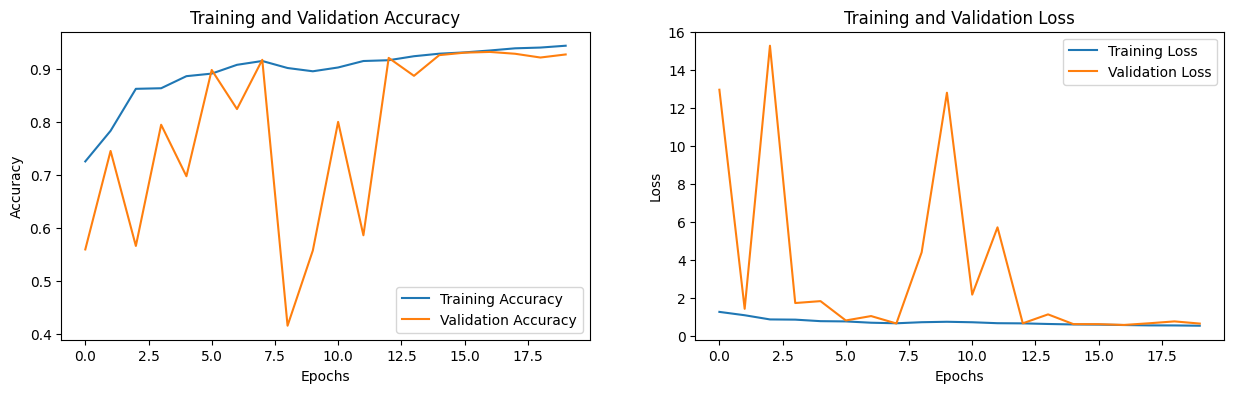

In [31]:
import matplotlib.pyplot as plt
EPOCHS = 20
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

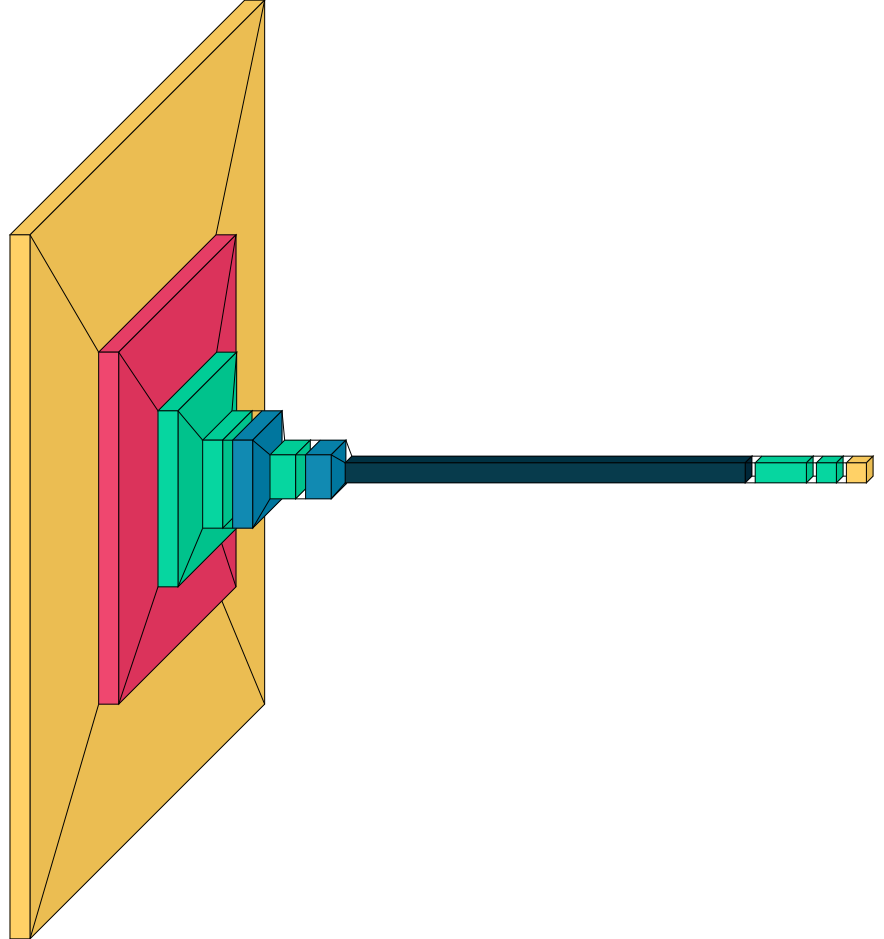

In [33]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
# Constants
IMG_SIZE = 176  # As defined earlier
test_dir = "AlzheimerDataset/test/"  # Specify the correct path to your test dataset


In [4]:

# Load the model
model = load_model("best_model.h5")


1/1 [==============================] - 0s 39ms/step


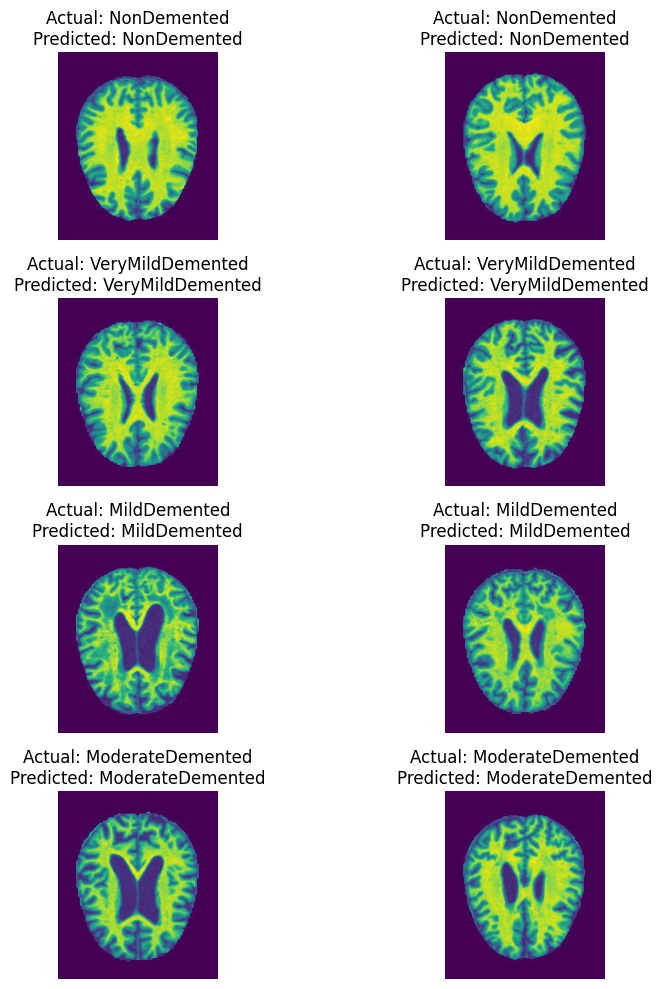

In [6]:

# A function to preprocess the images
def preprocess_image(image_path, img_size=IMG_SIZE):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images as input
    img /= 255.0  # Rescale
    return img

# Define Alzheimer's stages for prediction output
stages = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Initialize a 2x2 grid for subplots
plt.figure(figsize=(10, 10))

# Define the number of images per class
num_images_per_class = 2

# Loop through each class directory
for i, stage in enumerate(stages):
    stage_dir = os.path.join(test_dir, stage)
    
    # Get all images in this directory
    test_images = [os.path.join(stage_dir, f) for f in os.listdir(stage_dir) if os.path.isfile(os.path.join(stage_dir, f))]
    
    # Randomly select two images from this directory
    random_image_paths = random.sample(test_images, num_images_per_class)
    
    # Loop through selected images
    for j, random_image_path in enumerate(random_image_paths):
        img = preprocess_image(random_image_path)
        prediction = model.predict(img)
        predicted_class = stages[np.argmax(prediction)]
        # Add a subplot to the current figure
        plt.subplot(len(stages), num_images_per_class, i*num_images_per_class + j + 1)
        # Display the image, actual, and predicted class
        plt.imshow(plt.imread(random_image_path))
        plt.title(f'Actual: {stage}\nPredicted: {predicted_class}')
        plt.axis('off')  # Optional; hides the axis for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
